# Notebook de nettoyage

Dans le cadre du développement d'une application au service de la santé publique nous préparons les données nécessaires à une analyse de faisabilité.

L'application proposée aura pour but de répandre l'usage du nutriscore sur les produits disponibles en France.

L'intérêt de ce projet est de permettre au consomateur de **connaitre le profil nutritif d'une aliment quand bien même celui-ci ne serait pas affiché sur l'emballage.**

Cette étape de préparation des données à l'analyse a pour but de:
* récupérer des variables pertinentes pour l'application
* retirer les articles n'étant pas disponibles en France
* imputer les données manquantes nécessaires

Les données utilisées proviennent de la base de données OpenFoodFacts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.impute import KNNImputer

Nous chargeons en mémoire les données qui sont au départ sous format tsv (tab separated variable)

In [2]:
rawData = pd.read_csv('openfoodfacts.csv',sep='\t')

/home/paul/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,8,13,27,28,29,31,47,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# cette fonction permet d'expliciter automatiquement la description globale d'un tableau
def print_shape(dataframe): 
    print("Il s'agit d'un tableau de",
          dataframe.shape[0],'lignes et',
          dataframe.shape[1], "colonnes.")

In [4]:
print_shape(rawData)

Il s'agit d'un tableau de 1865997 lignes et 186 colonnes.


## Filtrage en fonction de la problématique
Nous avons besoin d'avoir :
- des informations nutritionnelles 
- sur des produits français

In [5]:
rawData.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'abbreviated_product_name', 'generic_name',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=186)

Au nombre de 186, l'exploration des colonnes n'est pas aisée.

Nous allons utiliser une fonction de recherche pour trouver celles qui nous intéressent.

In [6]:
# cette fonction va nous permettre de rechercher des colonnes pertinentes à notre problématique
def find_column(dataframe,keyword):
    return(list(dataframe.columns[
          (dataframe.columns.to_series()).str.contains(keyword,case=False)].values))

#### L'objectif ici va être de construire une **liste de noms de colonnes** nous permettant de trier notre dataset

In [7]:
listeTri = [] # initialisation de la colonne

### Informations nutritionnelles

Pour étudier le nutriscore nous devons nous intéresser à la quantité de :
- sel
- sucre
- calories
- graisse
- fibres
- protéines 
- fruits / légumes et fruits à coque

Référence : Chantal, J., Hercberg, S., & World Health Organization. (2017). Development of a new front-of-pack nutrition label in France: the five-colour Nutri-Score. Public Health Panorama, 3(04), 712-725.

Cette liste de thèmes de recherche va nous permettre de trouver les colonnes relatives au nutriscore.

In [8]:
# On cherche ici tout ce qui est relatif aux éléments de calcul du nutriscore
# Ainsi que toute mesure de score pouvant déjà être présente dans le jeu de données
themesNutrition = ['salt',
                   'sugar',
                   'energy',
                   'fat',
                   'fiber',
                   'protein',
                   'fruit',
                   'score']

Nous effectuons une recherche par terme et ajoutons les résultats de la recherche à notre liste de tri.

In [9]:
for theme in themesNutrition:
    indics = find_column(rawData,theme) # la fonction de recherche itérée sur chaque terme
    for indic in indics: # la deuxième boucle est nécessaire pour avoir une liste non nestée
        listeTri.append(indic)

Notre liste contient désormais toutes les valeurs relatives au nutriscore, nous l'utiliserons pour trier les colonnes après avoir filtré les produits indisponibles en France.

In [10]:
listeTri

['salt_100g',
 'sugars_100g',
 'energy-kj_100g',
 'energy-kcal_100g',
 'energy_100g',
 'energy-from-fat_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'omega-6-fat_100g',
 'omega-9-fat_100g',
 'trans-fat_100g',
 'fiber_100g',
 '-soluble-fiber_100g',
 '-insoluble-fiber_100g',
 'proteins_100g',
 'serum-proteins_100g',
 'collagen-meat-protein-ratio_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'nutriscore_score',
 'nutriscore_grade',
 'ecoscore_score_fr',
 'ecoscore_grade_fr',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

### Produits indisponibles en France
Dans la mesure où l'application est destinée au territoire français il n'est pas necessaire de fournir des renseignements sur des produits indisponibles dans le pays.

Recherche d'une colonne relative au pays nous permettant de faire un tri.

In [11]:
countryIndics = find_column(rawData,'countries')
countryIndics

['countries', 'countries_tags', 'countries_en']

Trois colonnes semblent répondre à nos critères mais laquelle utiliser ?

In [12]:
countriesMesures = rawData.loc[:,countryIndics]

In [13]:
countriesMesures.isna().sum(axis=0) # la quantité de valeurs nulles pour chacune des variables

countries         5633
countries_tags    5638
countries_en      5638
dtype: int64

L'une d'entre elles est à peine plus remplie que les autres

In [14]:
rawData['countries'].sample(10)

1097679    Denmark,France,Germany,Morocco,Switzerland
30304                                           en:us
1713730                                        France
1703149                                         en:es
769041                                          en:fr
1553462                                         en:it
973341                                         France
834451                                      en:France
1257057                                         en:it
497040                                         France
Name: countries, dtype: object

La notion de France peut se retrouver sous différents formats et parfois à coté d'autres pays, nous utilisons un pattern regex pour trouver des occurences comme France, france, en:france, en:FR etc.

In [15]:
# la recherche regex de 'france|en:fr' renvoie une série de booléens avec True pour chaque ligne contenant les mots désirés
maskFrance = rawData['countries'].str.contains('france|en:fr',case=False)
# On utilise l'index des valeurs égales à True dans maskFrance pour faire un subset sur les lignes de données et ainsi récupérer seulement les articles vendus en France
data = rawData.iloc[maskFrance[maskFrance == True].index,:] 

In [16]:
print_shape(data)

Il s'agit d'un tableau de 788613 lignes et 186 colonnes.


In [17]:
print('Nous avons réduit de',
      np.round((1-(data.shape[0]/rawData.shape[0]))*100,2),
      "% le nombre de lignes en ne gardant que les produits distribués en France.")

Nous avons réduit de 57.74 % le nombre de lignes en ne gardant que les produits distribués en France.


### Extraction des colonnes pertinentes
On utilise notre liste de colonnes construite supra  pour ne garder que les colonnes relatives au nutriscore.

In [18]:
data = data.loc[:,listeTri]

In [19]:
print('Il reste',data.shape[1],'colonnes par rapport aux',rawData.shape[1], 'initiales.')

Il reste 30 colonnes par rapport aux 186 initiales.


### Suppression des colonnes trop vides
Les colonnes avec trop peu de données ne pourront pas être analysées

In [20]:
# cette fonction renvoie un classement des colonnes les plus vides 
def taux_na_colonnes(dataframe):
    colsum = dataframe.isna().sum()
    colonnes = colsum.index
    valeurs = colsum.values
    pourcentage = np.round(((valeurs / dataframe.shape[0])*100),2)
    data_item = {'colonnes':colonnes,'taux NAN':valeurs,'pourcentage de NAN':pourcentage}
    return pd.DataFrame(data_item).sort_values(by='pourcentage de NAN',ascending=False)

On calcule le pourcentage de vide dans chacune des colonnes et le sauvegardons dans une table

In [21]:
dataNaN = taux_na_colonnes(data)
dataNaN.head(15)

,colonnes,taux NAN,pourcentage de NAN
29,nutrition-score-uk_100g,788607,100.00
19,serum-proteins_100g,788577,100.00
13,omega-9-fat_100g,788565,99.99
6,energy-from-fat_100g,788490,99.98
17,-insoluble-fiber_100g,788441,99.98
16,-soluble-fiber_100g,788435,99.98
5,energy-from-fat_100g,788490,99.98
22,fruits-vegetables-nuts-dried_100g,788292,99.96
12,omega-6-fat_100g,788331,99.96
20,collagen-meat-protein-ratio_100g,788315,99.96


In [22]:
dataNaN = dataNaN[dataNaN['pourcentage de NAN']<99.5] # On rejette tous les variables plus vides que 99.5%

Nous acceptons de garder des variables avec un très faible taux de remplissage car :

In [23]:
print("Seulement 0.5% de l'ensemble du jeu de données (soit",
      data.shape[0],
      'lignes) est égal à environ',
      int(data.shape[0]*0.005),
      'lignes.')

Seulement 0.5% de l'ensemble du jeu de données (soit 788613 lignes) est égal à environ 3943 lignes.


Ce qui représente une quantité d'informations non négligeable.

In [24]:
# la colonne 'colonnes' de dataNaN contient les noms des colonnes avec au moins 0.05% de remplissage.
data = data.loc[:,dataNaN['colonnes']]

In [25]:
print_shape(data)

Il s'agit d'un tableau de 788613 lignes et 16 colonnes.


### Visualisation de la quantité de données disponibles dans chaque colonne

In [26]:
def plot_na_columns(data):    
    quantiteData = data.describe(include='all').loc['count',:]
    quantiteData = quantiteData.astype(float).sort_values(ascending=False)
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    sns.barplot(ax=ax,
                x= quantiteData.values,
                y= quantiteData.index)
    plt.title('Quantité de lignes remplies par colonne',fontsize=20)
    ax.set(xlabel='Nombre de lignes non nulles',ylabel='Colonnes')

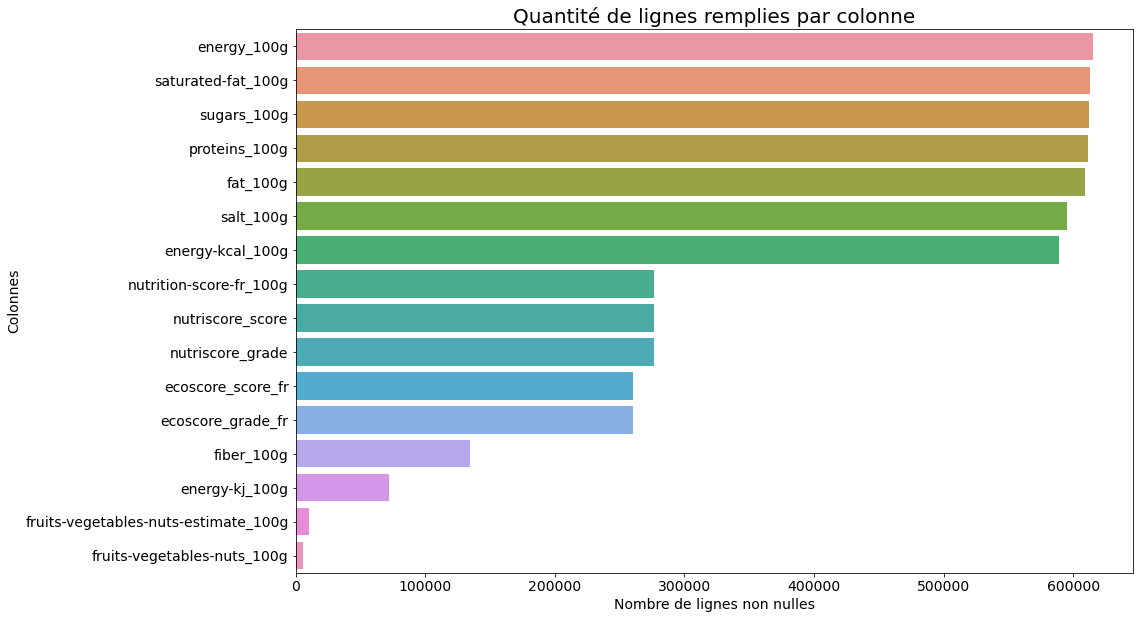

In [27]:
plot_na_columns(data)

Notre analyse va porter sur le rôle des différentes mesures nutritionnelles dans le calcul du nutriscore et les liens qui existent entre ces éléments.
* Etant donné la centralité du nutriscore dans notre analyse nous ne pouvons pas garder des lignes ne le contenant pas
* il en est de même pour la teneur en fruits et légumes qui est l'un des critères majeurs de calcul du score

In [28]:
data = data.dropna(subset=['nutriscore_score','fruits-vegetables-nuts_100g'])

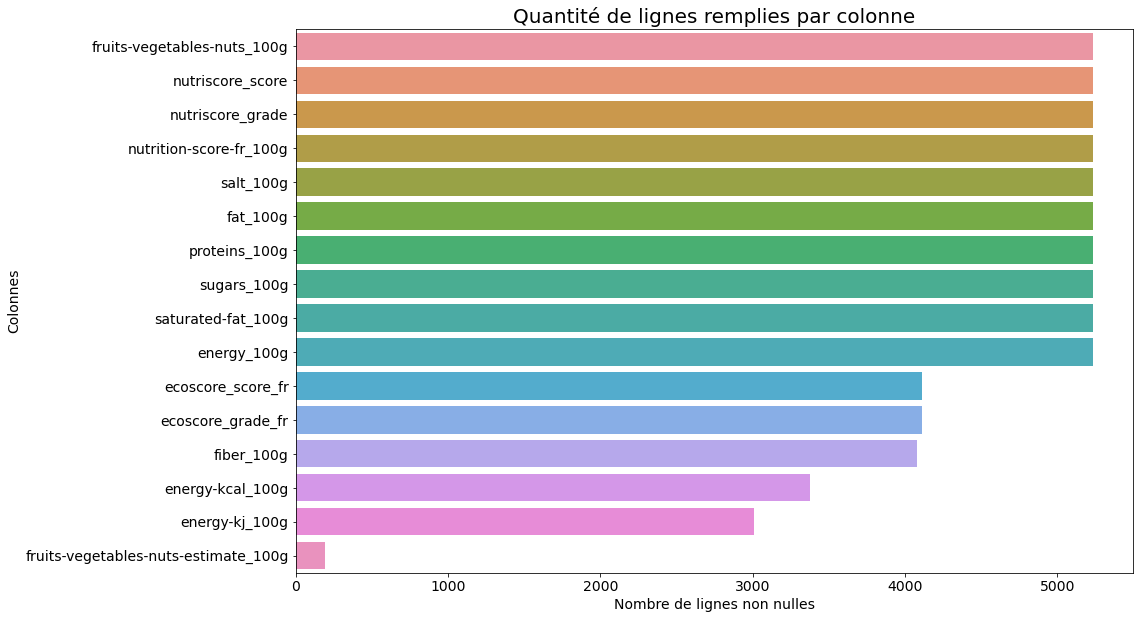

In [29]:
plot_na_columns(data)

Nous allons aussi nous débarasser d'autres variables :
* l'éco-score car notre analyse est seulement portée sur l'aspect nutritif des aliments
* l'énergie exprimée en kilocalories et kilojoules car l'on dispose déjà d'une mesure de l'énergie en beaucoup mieux renseignée  
* l'**estimation** de la teneur en fruits / légumes / fruits à coque car nous avons déjà la valeur réelle
* le nutriscore-fr pour 100g car cette information est redondante

In [30]:
data = data.drop(labels=['ecoscore_grade_fr',
                         'ecoscore_score_fr',
                         'energy-kcal_100g',
                         'energy-kj_100g',
                         'fruits-vegetables-nuts-estimate_100g',
                         'nutrition-score-fr_100g'],
                          axis = 1)

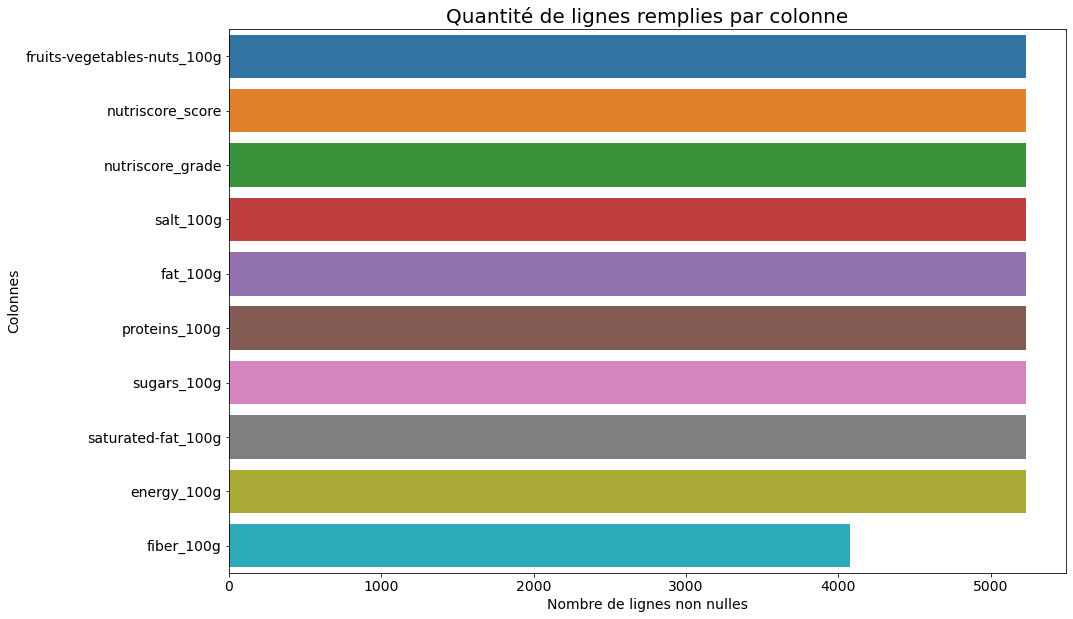

In [31]:
plot_na_columns(data)

On peut observer qu'une portion des données concernant les fibres est manquante
* Nous allons essayer d'imputer les données manquantes

Cependant avant celà nous allons nous traiter les éventuelles données aberrantes présentes dans notre tableau

## Traitement des valeurs aberrantes et dupliquées
Ce que l'on cherche pour trouver ces valeurs aberrantes :

- mesures : ce qui est supérieur à 100 ou négatif (la valeur doit être comprise entre 0 et 100 pour mesurer 100g d'un élément) sauf pour l'energie qui est exprimée en kiloJoules
- nutriscore : tout ce qui n'est pas compris entre -15 et 40 (les deux valeurs extrêmes que peut prendre le score)
- nutrigrade : autre chose que les lettres du nutriscore

Afin de faciliter les traitements nous déplaçons le nutriscore/grade et fibres aux dernières colonnes du tableau

In [32]:
nutriScore = data.pop('nutriscore_score')
nutriGrade = data.pop('nutriscore_grade')
fibers = data.pop('fiber_100g')
data.insert(len(data.columns),'fiber_100g',fibers)
data.insert(len(data.columns),'nutriscore_score',nutriScore)
data.insert(len(data.columns),'nutriscore_grade',nutriGrade)

### Suppression des lignes dupliquées

In [33]:
data.shape

(5232, 10)

In [34]:
data = data.drop_duplicates()

In [35]:
data.shape

(4769, 10)

Nous avons supprimé un peu moins de 500 lignes.

### Aberrations dans les mesures sur 100g

Construction d'une table contenant les mesures pour 100g (sauf energie)

In [36]:
mesuresGrammes = data.loc[:,'fruits-vegetables-nuts_100g':'saturated-fat_100g']

Cette fonction nous permet de renvoyer l'index des valeurs se trouvant en dehors d'un intervalle donné.

In [37]:
def detect_aber(serie,upper,lower):
    bound1 = serie[serie > upper].index
    bound2 = serie[serie < lower].index
    return (bound1.append(bound2)).unique()

On initialise une liste qui contiendra les indexs des lignes contenant des valeurs aberrantes

In [38]:
aberrations = []

In [39]:
for i in range(0,len(mesuresGrammes.columns)):
     aberrations.append(detect_aber(mesuresGrammes.iloc[:,i],100,0))

In [40]:
aberrations

[Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64')]

La liste est vide, il n'y a pas de valeurs en dehors de l'intervalle 0 - 100 grammes

### Aberrations dans les mesures du Nutriscore

In [41]:
detect_aber(data['nutriscore_score'],40,-15) # 40 représente la pire note nutriscore et -15 la meilleure possible

Int64Index([], dtype='int64')

Ici aussi la liste est vide ce qui nous montre que le Nutriscore ne contient pas de valeurs aberrantes

### Aberrations dans la quotation Nutrigrade
Toute valeur autre que 'a','b','c','d','e' n'est pas censée exister dans cette colonne

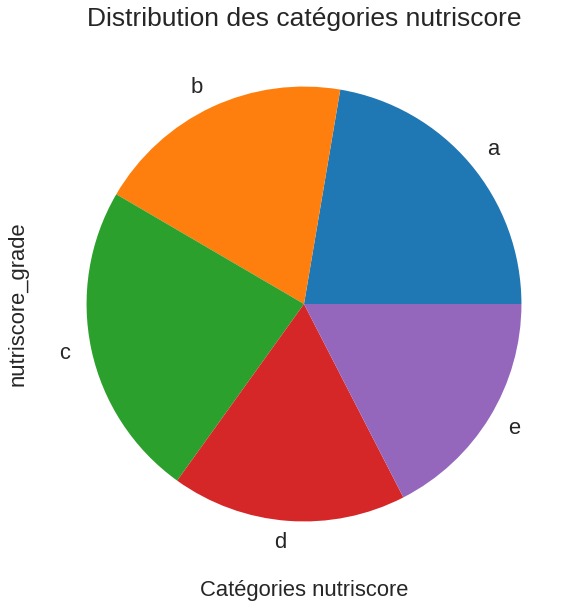

In [42]:
nutrigrade = data['nutriscore_grade'].value_counts().sort_index()
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
plt.title('Distribution des catégories nutriscore')
plt.xlabel('Catégories nutriscore')
plt.ylabel('Quantité de produits')
nutrigrade.plot.pie(x=nutrigrade.index,y=nutrigrade.values);

Si une valeur aberrante était présente elle serait apparue comme une catégorie de plus, or ce n'est pas le cas

## Imputation des valeurs manquantes par K Nearest Neighbours

In [43]:
taux_na_colonnes(data).head()

,colonnes,taux NAN,pourcentage de NAN
7,fiber_100g,1123,23.55
0,fruits-vegetables-nuts_100g,0,0.00
1,salt_100g,0,0.00
2,fat_100g,0,0.00
3,proteins_100g,0,0.00


On peut observer que 23.55% des données relatives aux fibres sont manquantes.

Cependant ce critère est essentiel au calcul du nutriscore
- Nous allons tenter d'imputer ces valeurs manquantes à l'aide d'un algorithme KNN

### Choix des K-voisins
Avant d'utiliser un modèle KNN pour imputer nos données manquantes nous devons estimer la meilleure valeur de l'hyperparamètre K.

Pour ce faire nous allons mesurer l'erreur de prédiction moyenne d'un modèle KNN sur la teneur en fibre par validation croisée.

Nous commençons par retirer les valeurs où les données fibres sont manquantes.

In [44]:
knnData = data.dropna()

In [45]:
knnData.sample(10)

,fruits-vegetables-nuts_100g,salt_100g,fat_100g,proteins_100g,sugars_100g,saturated-fat_100g,energy_100g,fiber_100g,nutriscore_score,nutriscore_grade
754181,12.00,0.01,0.50,0.5,9.4,0.1,160.0,0.5,13.0,e
921213,35.00,0.49,14.00,4.2,29.0,1.5,1577.0,2.5,11.0,d
683116,50.00,0.00,0.00,0.0,5.1,0.0,96.0,0.0,6.0,d
1600851,83.00,1.00,4.00,1.4,5.0,0.3,285.0,1.5,-1.0,a
928135,100.00,0.10,0.50,2.5,0.8,0.1,93.0,2.1,-8.0,a
762828,0.00,0.01,1.58,11.0,2.9,0.3,1515.0,5.8,-6.0,a
720607,0.00,1.25,4.60,8.5,5.0,0.5,1043.0,7.7,-1.0,a
932366,37.02,1.00,2.60,7.0,2.4,1.1,521.0,4.2,-2.0,a
1058404,39.90,0.04,0.50,0.5,5.4,0.1,92.0,0.5,8.0,d
930520,23.31,0.80,3.80,5.1,2.9,1.7,443.0,1.4,1.0,b


### Standardisation des données et séparation entrainement / test

In [46]:
# Cette fonction va nous permettre de standardiser notre matrice d'entrainement
def standardise(X):
    X = (X - X.mean(axis=0)) / X.std()
    return X

In [47]:
X = knnData.drop(['fiber_100g','nutriscore_grade'],axis=1)
y = knnData['fiber_100g']
X = standardise(X)
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2)

Définition des paramètres de la validation croisée.

In [48]:
cv = KFold(n_splits = 4, # environ 1000 lignes pour faire un entrainement / test
           shuffle=True, # on randomise l'ordre des données si jamais celles-ci contenaient un ordre que l'on a pas détecté
           random_state=1) # on donne une seed à l'aléatoire pour la reproductibilité des résultats

Calcul de l'erreur moyenne pour tous les modèles entre 2 et 15 voisins

In [49]:
nK = list(range(2,16))
error = []
for i in nK:
    model = KNeighborsRegressor(n_neighbors=i)
    scores = cross_val_score(model,X,y, cv=cv, n_jobs=-1)
    score = scores.mean()
    error.append(score)

Visualisation des erreurs

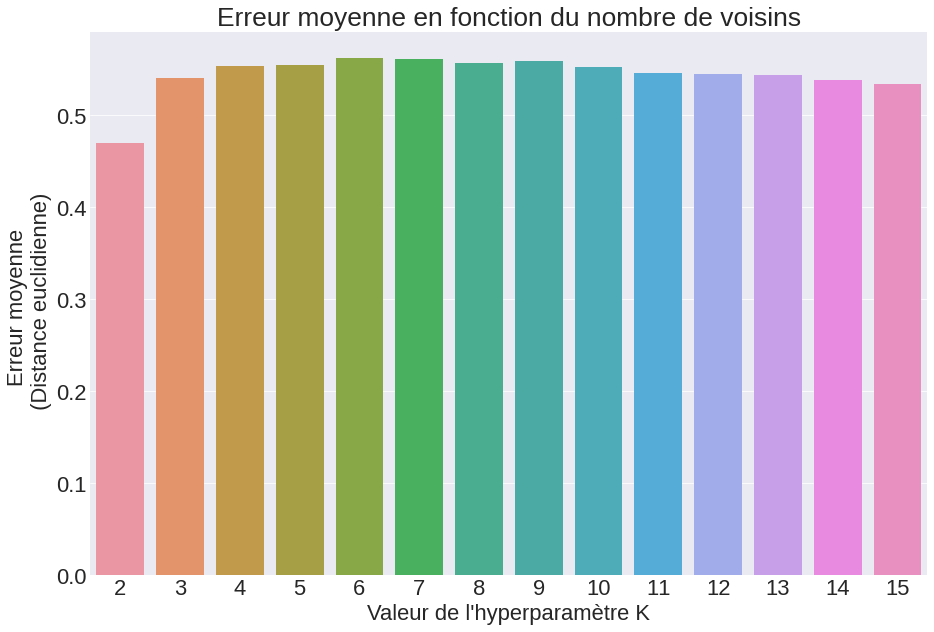

In [50]:
plt.figure(figsize=(15,10))
plt.title("Erreur moyenne en fonction du nombre de voisins")
plt.xlabel("Valeur de l'hyperparamètre K")
plt.ylabel("Erreur moyenne \n (Distance euclidienne)")
sns.barplot(x=nK,y=error);

Un hyperparamètre K=2 semble fournir la meilleure précision prédictive.

In [51]:
model = KNeighborsRegressor(n_neighbors=2)
model.fit(X,y)

KNeighborsRegressor(n_neighbors=2)

In [52]:
y_pred = model.predict(x_test)

In [53]:
RMSE = np.sqrt((np.sum((y_test.values - y_pred)**2)) / len(y_pred))

In [54]:
print("Avec K = 2, le modèle se trompe d'environ",np.round(RMSE,2),'grammes dans la prédiction de la teneur en fibres.')

Avec K = 2, le modèle se trompe d'environ 1.69 grammes dans la prédiction de la teneur en fibres.


### Imputation des données
Maintenant que nous connaissons le nombre de voisins optimal nous allons imputer les données manquantes.

In [55]:
imputer = KNNImputer(n_neighbors=2)

Nous calculons l'imputation sur un sous ensemble des données ne contenant pas la note en lettres du nutriscore, celle-ci n'ajoute pas d'information et le modèle KNN ne fonctionne pas avec des lettres.

In [56]:
dataKnn = data.drop('nutriscore_grade',axis=1)
imputedData = imputer.fit_transform(dataKnn)

Une fois les données imputées calculées celles-ci sortent en format numpy array.
- Nous récupérons la colonne des fibres avec imputation et l'insérons dans notre dataframe.

In [57]:
# On utilise l'index colonne numérique qui correspond aux fibres dans le dataframe pour faire le subset de la colonne sur l'array
data['KNN-imputed-fiber_100g'] = imputedData[:,dataKnn.columns.get_loc('fiber_100g')] 
# les fibres imputées sont désormais présentes dans notre jeu de données
data.sample(10)

,fruits-vegetables-nuts_100g,salt_100g,fat_100g,proteins_100g,sugars_100g,saturated-fat_100g,energy_100g,fiber_100g,nutriscore_score,nutriscore_grade,KNN-imputed-fiber_100g
720490,0.00,1.250000,4.3,9.0,6.5,0.5,1195.0,3.7,1.0,b,3.70
929305,2.25,0.000000,0.5,0.5,0.6,0.1,45.0,2.9,-3.0,a,2.90
929030,100.00,0.000000,0.5,0.5,10.0,0.1,174.0,0.5,3.0,c,0.50
1418265,100.00,0.100000,0.5,3.5,53.0,0.5,1070.0,7.0,1.0,b,7.00
748182,36.00,0.024994,0.0,0.2,10.6,0.0,205.0,0.5,15.0,e,0.50
758477,55.00,0.030000,0.0,0.3,9.3,0.0,159.0,NaN,1.0,b,1.25
693618,0.00,2.100000,23.0,14.0,2.5,9.2,1151.0,1.2,20.0,e,1.20
509166,0.00,1.900000,13.0,16.0,0.5,3.8,782.0,1.4,12.0,d,1.40
1600661,0.00,0.013000,2.0,14.0,3.5,0.4,1521.0,3.0,-4.0,a,3.00
928499,14.18,1.100000,5.2,10.7,3.5,1.9,932.0,1.9,1.0,b,1.90


### Imputation des valeurs manquantes par la moyenne
Dans un souci de comparaison avec notre variable imputée par KNN nous faisons aussi une imputation plus classique par la moyenne.

In [58]:
data['mean-imputed-fiber_100g'] = data['fiber_100g'].fillna(data['fiber_100g'].mean())

### Comparaison des méthodes d'imputation des fibres
Nous observons les différences entre la variable sans imputation et les différentes méthodes d'imputation pour nous donner une idée de laquelle est la plus fidèle à la distribution originale.

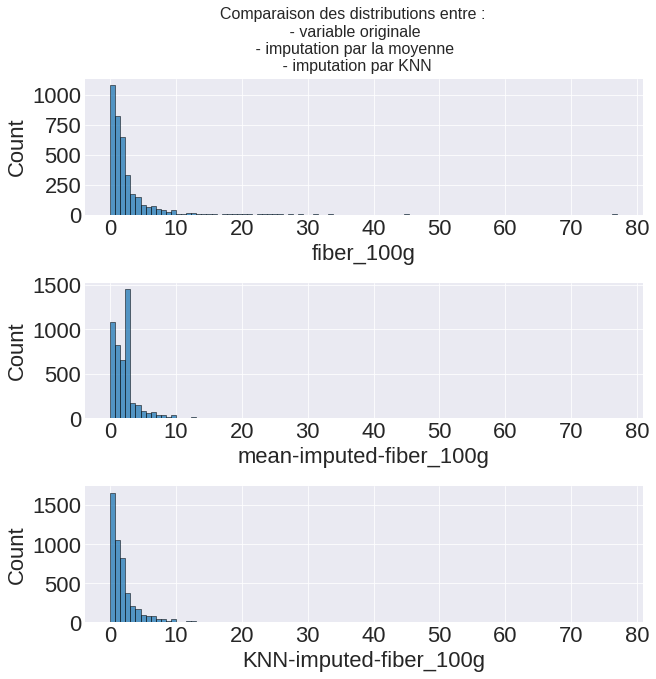

In [59]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Comparaison des distributions entre : \n - variable originale \n - imputation par la moyenne \n - imputation par KNN',
            fontsize=16)
sns.histplot(ax = ax[0],x=data['fiber_100g'],bins=100)
sns.histplot(ax = ax[1],x=data['mean-imputed-fiber_100g'],bins=100)
sns.histplot(ax = ax[2],x=data['KNN-imputed-fiber_100g'],bins=100);

L'imputation par KNN semble beaucoup plus proche de la variable originale 
- nous ne garderons que celle-ci pour l'analyse

In [60]:
data.drop(['fiber_100g','mean-imputed-fiber_100g'],axis=1,inplace=True)

In [61]:
data.sample(10)

,fruits-vegetables-nuts_100g,salt_100g,fat_100g,proteins_100g,sugars_100g,saturated-fat_100g,energy_100g,nutriscore_score,nutriscore_grade,KNN-imputed-fiber_100g
1002418,100.00,0.00,0.03,0.4,2.0,0.00,113.0,-4.0,b,2.05
925400,100.00,0.50,0.40,4.9,4.4,0.00,331.0,-11.0,a,6.10
930026,97.27,0.00,0.80,0.5,12.0,0.20,265.0,-5.0,a,2.00
925702,100.00,0.83,1.00,8.6,0.9,0.60,456.0,-11.0,a,6.50
1338578,10.00,0.01,0.00,0.0,1.5,0.00,25.0,2.0,c,0.00
791741,0.00,1.00,6.30,20.0,0.0,2.10,586.0,1.0,b,1.40
930874,12.00,0.00,0.50,0.5,9.5,0.10,162.0,13.0,e,0.50
1306545,100.00,0.00,0.00,0.8,11.4,0.00,230.0,5.0,c,1.30
993718,55.00,0.01,0.05,0.4,12.0,0.05,226.0,13.0,e,1.00
732322,50.00,0.02,0.50,0.5,40.0,0.10,690.0,9.0,c,1.20


A nouveau nous faisons passer nutriscore et nutrigrade aux dernières colonnes ce qui nous permettra un traitement plus facile dans la partie analyse.

In [62]:
nutriScore = data.pop('nutriscore_score')
nutriGrade = data.pop('nutriscore_grade')
data.insert(len(data.columns),'nutriscore_score',nutriScore)
data.insert(len(data.columns),'nutriscore_grade',nutriGrade)

In [63]:
data.sample(10)

,fruits-vegetables-nuts_100g,salt_100g,fat_100g,proteins_100g,sugars_100g,saturated-fat_100g,energy_100g,KNN-imputed-fiber_100g,nutriscore_score,nutriscore_grade
729914,10.10,0.90,7.3,8.5,1.5,1.3,764.0,1.2,0.0,b
927040,99.00,0.00,0.5,0.5,11.0,0.0,239.0,2.1,-5.0,a
968635,22.00,0.53,15.8,8.1,1.3,4.9,919.0,1.9,2.0,b
925413,100.00,0.55,0.3,0.6,2.2,0.1,96.0,2.3,-5.0,a
940352,50.00,0.09,0.5,0.5,63.0,0.5,1382.0,3.9,13.0,d
747323,40.00,0.83,5.0,8.5,0.8,1.8,481.0,2.0,-2.0,a
928928,60.55,0.90,5.6,1.4,4.5,0.8,334.0,1.8,0.0,b
507432,0.00,2.00,21.0,9.0,5.0,13.0,1025.0,0.0,17.0,d
929472,6.70,0.50,17.0,6.6,30.0,7.4,1904.0,3.0,17.0,d
509167,0.00,1.10,1.7,22.0,0.8,0.6,481.0,1.3,-1.0,a


### Le travail de préparation est terminé.

Nous écrivons les données sur disque et poursuivons la démarche dans le notebook suivant.

In [64]:
data.to_csv('data_clean.csv',
            sep='\t',
            index = False)